# Data Load


In [ ]:
# Install if not already installed
!pip install -q kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the specific file you want to load, for example, 'results.csv'
file_path = "results.csv"

# Load the dataset as a pandas DataFrame
df_results = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "rohanrao/formula-1-world-championship-1950-2020",
    file_path
)

print("First 5 records:")
print(df_results.head())


#split the data by racer
# be careful about splits on testing and training (data leakage & watch out for duplicates & row amount)

<ipython-input-1-4737ffbb1a3a>:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_results = kagglehub.load_dataset(


First 5 records:
   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300         1  
1

In [ ]:
results = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rohanrao/formula-1-world-championship-1950-2020", "results.csv")
races = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rohanrao/formula-1-world-championship-1950-2020", "races.csv")
drivers = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rohanrao/formula-1-world-championship-1950-2020", "drivers.csv")
constructors = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rohanrao/formula-1-world-championship-1950-2020", "constructors.csv")
qualifying = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rohanrao/formula-1-world-championship-1950-2020", "qualifying.csv")

<ipython-input-2-b301a8f1e565>:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  results = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rohanrao/formula-1-world-championship-1950-2020", "results.csv")
<ipython-input-2-b301a8f1e565>:2: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  races = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rohanrao/formula-1-world-championship-1950-2020", "races.csv")
<ipython-input-2-b301a8f1e565>:3: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  drivers = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rohanrao/formula-1-world-championship-1950-2020", "drivers.csv")
<ipython-input-2-b301a8f1e565>:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  constructors = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "rohanrao/formula-1-world-championship-1950-2020", "const

In [ ]:
# Merge datasets
df = results.merge(races[['raceId', 'year', 'round', 'date', 'circuitId']], on='raceId', how='left')
df = df.merge(drivers[['driverId', 'driverRef', 'nationality']], on='driverId', how='left')
df = df.merge(constructors[['constructorId', 'name']], on='constructorId', how='left')
df = df.merge(qualifying[['raceId', 'driverId', 'position']], on=['raceId', 'driverId'], how='left', suffixes=('', '_qual'))

# Binary Classification of Features

In [ ]:
df.rename(columns={
    'positionOrder': 'finish_position',
    'position_qual': 'qualifying_position',
    'name': 'constructor_name',
    'driverRef': 'driver_name',
}, inplace=True)

In [ ]:
df = df.dropna(subset=['finish_position', 'qualifying_position'])
df = df.drop_duplicates(subset=['raceId', 'driverId'])

In [ ]:
# Convert types
df['finish_position'] = df['finish_position'].astype(int)
df['qualifying_position'] = df['qualifying_position'].astype(int)

In [ ]:
# Binary Classification
df['podium'] = df['finish_position'].apply(lambda x: 1 if x <= 3 else 0)

<Figure size 640x480 with 0 Axes>

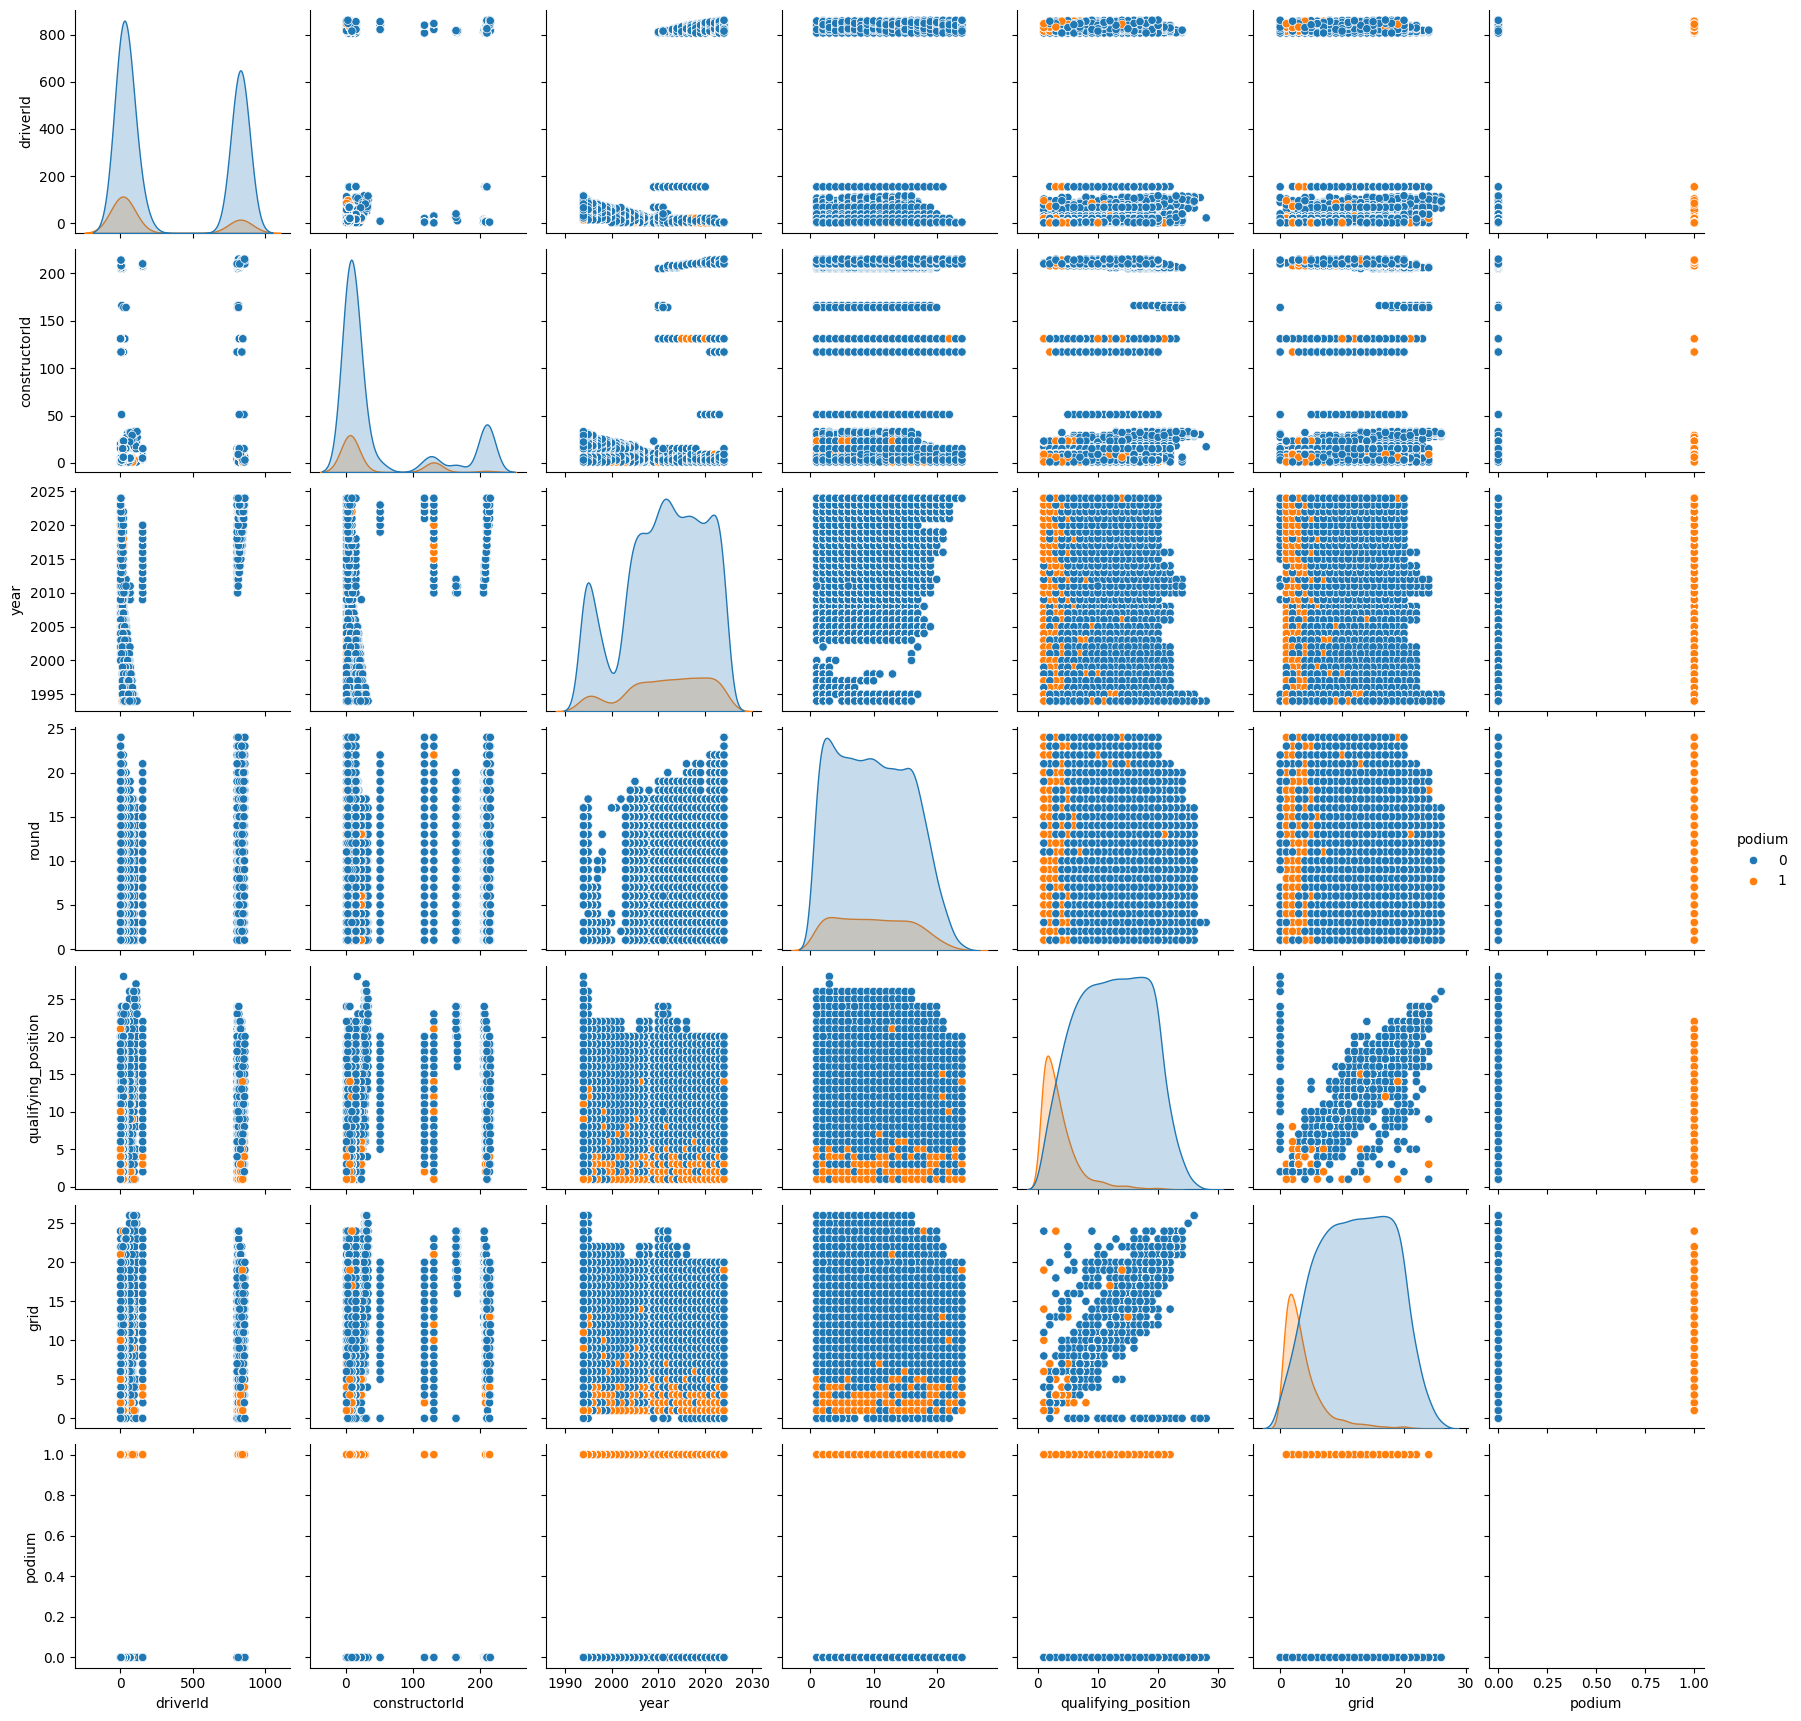

In [ ]:
import matplotlib.pyplot as plt # Import the matplotlib library and assign it to the alias 'plt'
import seaborn as sns # Import the seaborn library
plt.figure()
features = ['driverId',
    'constructorId',
    'year',
    'round',
    'qualifying_position',
    'grid',
    'podium']
sns.pairplot(df, vars=features, hue='podium')

In [ ]:
df_features = df[[
    'driverId',
    'constructorId',
    'year',
    'round',
    'qualifying_position',
    'grid',
    'podium'
]].copy()

In [ ]:
# Encode IDs
df_features['driverId'] = df_features['driverId'].astype("category").cat.codes
df_features['constructorId'] = df_features['constructorId'].astype("category").cat.codes

In [ ]:
df_train = df_features[df_features['year'] < 2018]
df_test = df_features[df_features['year'] >= 2018]

# Random Forest Classifier


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
X = df_train.drop(columns=["podium"])
y = df_train["podium"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y)

X_test = df_test.drop(columns=["podium"])
y_test = df_test["podium"]

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4510, 6)
Validation set shape: (3008, 6)
Test set shape: (2976, 6)


In [ ]:
# Finding the best number of trees for the model
best_auc = 0
best_n = 0
auc_scores = []

for n in range(100, 1100, 100):
    rf = RandomForestClassifier(
        n_estimators=n,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    y_val_proba = rf.predict_proba(X_val)[:, 1]
    auc_val = roc_auc_score(y_val, y_val_proba)
    auc_scores.append((n, auc_val))

    print(f"n_estimators: {n}, Validation ROC AUC: {auc_val:.4f}")

    if auc_val > best_auc:
        best_auc = auc_val
        best_n = n

print(f"\nBest n_estimators: {best_n} with AUC: {best_auc:.4f}")

n_estimators: 100, Validation ROC AUC: 0.9109
n_estimators: 200, Validation ROC AUC: 0.9112
n_estimators: 300, Validation ROC AUC: 0.9115
n_estimators: 400, Validation ROC AUC: 0.9117
n_estimators: 500, Validation ROC AUC: 0.9114
n_estimators: 600, Validation ROC AUC: 0.9115
n_estimators: 700, Validation ROC AUC: 0.9115
n_estimators: 800, Validation ROC AUC: 0.9115
n_estimators: 900, Validation ROC AUC: 0.9116
n_estimators: 1000, Validation ROC AUC: 0.9116

Best n_estimators: 400 with AUC: 0.9117


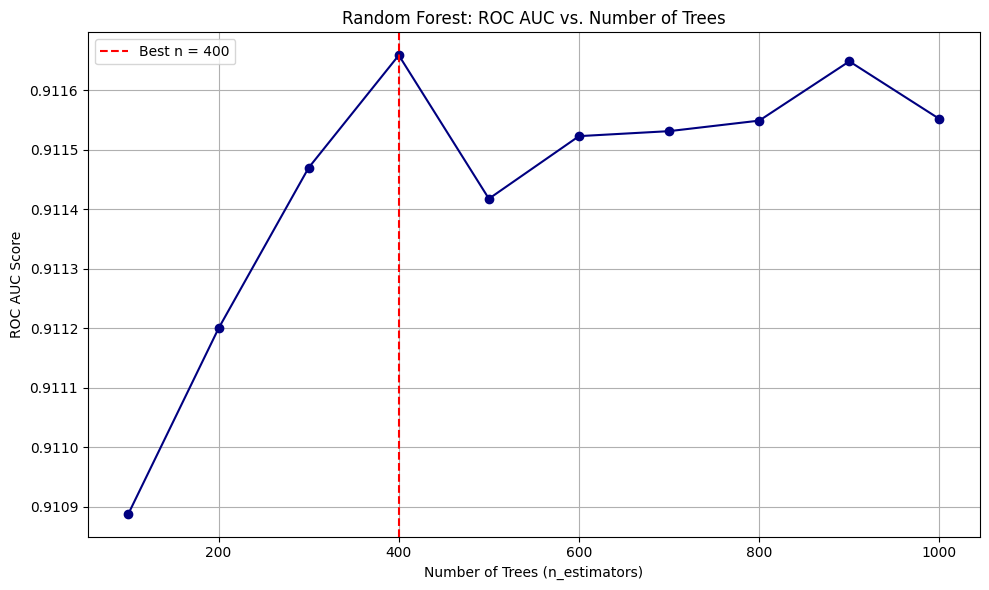

In [ ]:
n_vals, auc_vals = zip(*auc_scores)

plt.figure(figsize=(10, 6))
plt.plot(n_vals, auc_vals, marker='o', linestyle='-', color='navy')
plt.title("Random Forest: ROC AUC vs. Number of Trees")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("ROC AUC Score")
plt.grid(True)
plt.axvline(best_n, color='red', linestyle='--', label=f"Best n = {best_n}")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=best_n,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'
)

In [ ]:
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy", rf_model.score(X_test, y_test))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      2529
           1       0.57      0.78      0.66       447

    accuracy                           0.88      2976
   macro avg       0.76      0.84      0.79      2976
weighted avg       0.90      0.88      0.89      2976

Accuracy 0.8790322580645161
ROC-AUC Score: 0.9162608594885459


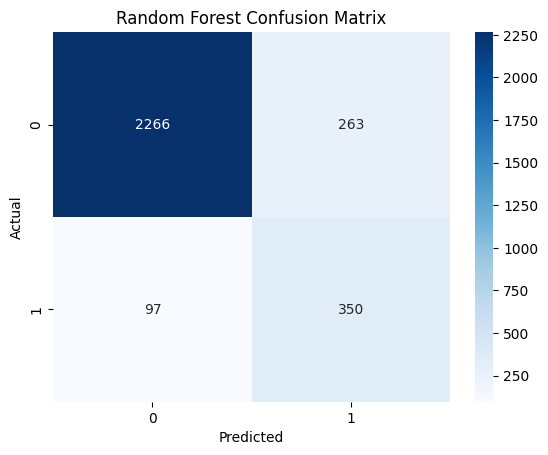

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

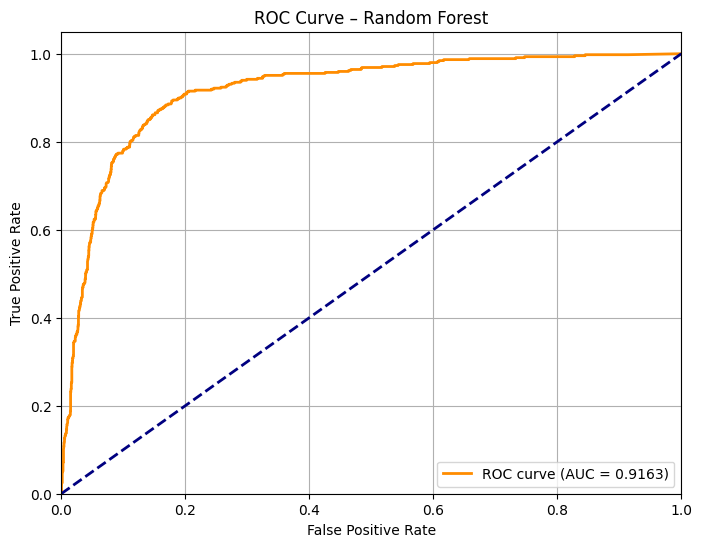

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Random Forest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

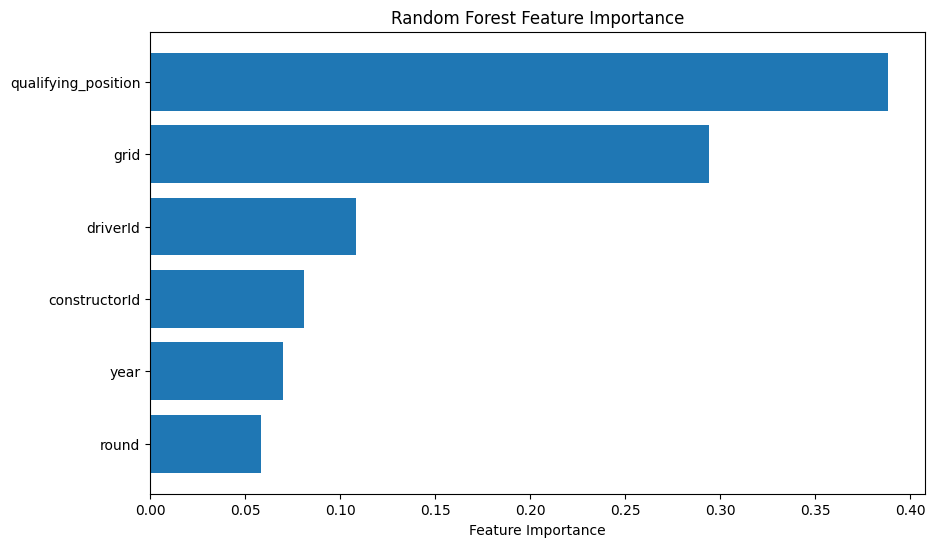

In [ ]:
# Feature Importance
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort the features by importance
sorted_idx = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

# Multi-Layer Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


class NumpyDataset(torch.utils.data.Dataset):
    def __init__(self, input_array, target_output_array):
        self.input_tensor = torch.from_numpy(input_array).float()
        self.output_tensor = torch.from_numpy(target_output_array).float().reshape(-1, 1)

    def __len__(self):
        return len(self.input_tensor)

    def __getitem__(self, index):
        X = self.input_tensor[index]
        y = self.output_tensor[index]
        return X, y

class F1PodiumPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = F.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

def train(model, data_generator, loss_function, optimizer):
    model.train()
    avg_loss = 0
    correct = 0
    total = 0
    for input_data, target_output in data_generator:
        optimizer.zero_grad()
        prediction = model(input_data)
        loss = loss_function(prediction, target_output)
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        predicted = (prediction >= 0.5).float()
        total += target_output.size(0)
        correct += (predicted == target_output).sum().item()
    num_batches = len(data_generator)
    accuracy = 100 * correct / total
    return avg_loss / num_batches, accuracy

def test(model, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_probs = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_function(output, target).item()
            predicted = (output >= 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_probs.append(output.cpu().numpy())
            all_targets.append(target.cpu().numpy())
    num_batches = len(test_loader)
    accuracy = 100 * correct / total
    all_probs = np.concatenate(all_probs).flatten()
    all_targets = np.concatenate(all_targets).flatten()
    return test_loss / num_batches, accuracy, all_probs, all_targets

def logResults(epoch, num_epochs, train_loss, train_acc, train_loss_history, train_acc_history,
               test_loss, test_acc, test_loss_history, test_acc_history, epoch_counter, print_interval=5):
    if epoch % print_interval == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_loss_history.append(test_loss)
    test_acc_history.append(test_acc)
    epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(epoch_counter, train_loss_hist, 'b', label='Train Loss')
    ax1.plot(epoch_counter, test_loss_hist, 'r', label='Test Loss')
    ax1.set_xlabel('#Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(epoch_counter, train_acc_hist, 'b', label='Train Accuracy')
    ax2.plot(epoch_counter, test_acc_hist, 'r', label='Test Accuracy')
    ax2.set_xlabel('#Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    plt.tight_layout()
    plt.savefig('training_metrics.png')

def trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, logging_interval=5):
    test_loss_history = []
    train_loss_history = []
    test_acc_history = []
    train_acc_history = []
    epoch_counter = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, training_generator, loss_function, optimizer)
        test_loss, test_acc, _, _ = test(model, testing_generator, loss_function)
        logResults(epoch, num_epochs, train_loss, train_acc, train_loss_history, train_acc_history,
                   test_loss, test_acc, test_loss_history, test_acc_history, epoch_counter, logging_interval)

    _, final_test_acc, final_probs, final_targets = test(model, testing_generator, loss_function)
    final_preds = (final_probs >= 0.5).astype(float)
    precision = precision_score(final_targets, final_preds)
    recall = recall_score(final_targets, final_preds)
    f1 = f1_score(final_targets, final_preds)
    accuracy = accuracy_score(final_targets, final_preds)
    auc_score = roc_auc_score(final_targets, final_probs)

    print("\nFinal Test Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")

    graphLoss(epoch_counter, train_loss_history, test_loss_history, train_acc_history, test_acc_history)

    fpr, tpr, _ = roc_curve(final_targets, final_probs)

    # Random Forest ROC
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba)
    roc_auc_rf = auc(fpr_rf, tpr_rf)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.4f})')
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve.png')

    return final_targets, final_preds



Testing: lr=0.0001, batch_size=16, epochs=50
Epoch [1/50], Train Loss: 26.2789, Train Acc: 54.97%, Test Loss: 2.9017, Test Acc: 84.98%
Epoch [6/50], Train Loss: 0.7003, Train Acc: 79.62%, Test Loss: 0.4359, Test Acc: 84.98%
Epoch [11/50], Train Loss: 0.4762, Train Acc: 84.39%, Test Loss: 0.4701, Test Acc: 84.98%
Epoch [16/50], Train Loss: 0.4399, Train Acc: 85.72%, Test Loss: 0.4927, Test Acc: 84.98%
Epoch [21/50], Train Loss: 0.4314, Train Acc: 85.99%, Test Loss: 0.4225, Test Acc: 84.98%
Epoch [26/50], Train Loss: 0.4135, Train Acc: 86.12%, Test Loss: 0.4324, Test Acc: 84.98%
Epoch [31/50], Train Loss: 0.4149, Train Acc: 86.12%, Test Loss: 0.4326, Test Acc: 84.98%
Epoch [36/50], Train Loss: 0.4115, Train Acc: 86.12%, Test Loss: 0.4184, Test Acc: 84.98%
Epoch [41/50], Train Loss: 0.4118, Train Acc: 86.19%, Test Loss: 0.4171, Test Acc: 84.98%
Epoch [46/50], Train Loss: 0.4031, Train Acc: 86.19%, Test Loss: 0.4154, Test Acc: 84.98%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Test Metrics:
Accuracy: 0.8498
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: 0.8126
Results: Accuracy=0.8498, F1 Score=0.0000

Testing: lr=0.001, batch_size=16, epochs=50
Epoch [1/50], Train Loss: 10.6442, Train Acc: 75.48%, Test Loss: 0.4486, Test Acc: 84.98%
Epoch [6/50], Train Loss: 0.4316, Train Acc: 86.14%, Test Loss: 0.4185, Test Acc: 84.98%
Epoch [11/50], Train Loss: 0.3941, Train Acc: 86.21%, Test Loss: 0.3976, Test Acc: 84.98%
Epoch [16/50], Train Loss: 0.3455, Train Acc: 86.25%, Test Loss: 0.3647, Test Acc: 84.98%
Epoch [21/50], Train Loss: 0.3036, Train Acc: 86.32%, Test Loss: 0.3064, Test Acc: 84.98%
Epoch [26/50], Train Loss: 0.2828, Train Acc: 86.23%, Test Loss: 0.2846, Test Acc: 84.98%
Epoch [31/50], Train Loss: 0.2688, Train Acc: 86.23%, Test Loss: 0.2644, Test Acc: 84.98%
Epoch [36/50], Train Loss: 0.2652, Train Acc: 88.18%, Test Loss: 0.2764, Test Acc: 86.93%
Epoch [41/50], Train Loss: 0.2565, Train Acc: 88.94%, Test Loss: 0.2662, Test Acc: 87.13

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Final Test Metrics:
Accuracy: 0.8498
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: 0.5000
Results: Accuracy=0.8498, F1 Score=0.0000

Hyperparameter tuning completed. Results:
lr=0.0001, batch_size=16, epochs=50, Accuracy=0.8498, F1 Score=0.0000
Final Targets: [1.0, 1.0, 1.0, 0.0, 0.0]...
Final Predictions: [0, 0, 0, 0, 0]...
lr=0.001, batch_size=16, epochs=50, Accuracy=0.8844, F1 Score=0.4896
Final Targets: [1.0, 1.0, 1.0, 0.0, 0.0]...
Final Predictions: [0, 1, 1, 0, 0]...
lr=0.01, batch_size=16, epochs=50, Accuracy=0.8498, F1 Score=0.0000
Final Targets: [1.0, 1.0, 1.0, 0.0, 0.0]...
Final Predictions: [0, 0, 0, 0, 0]...


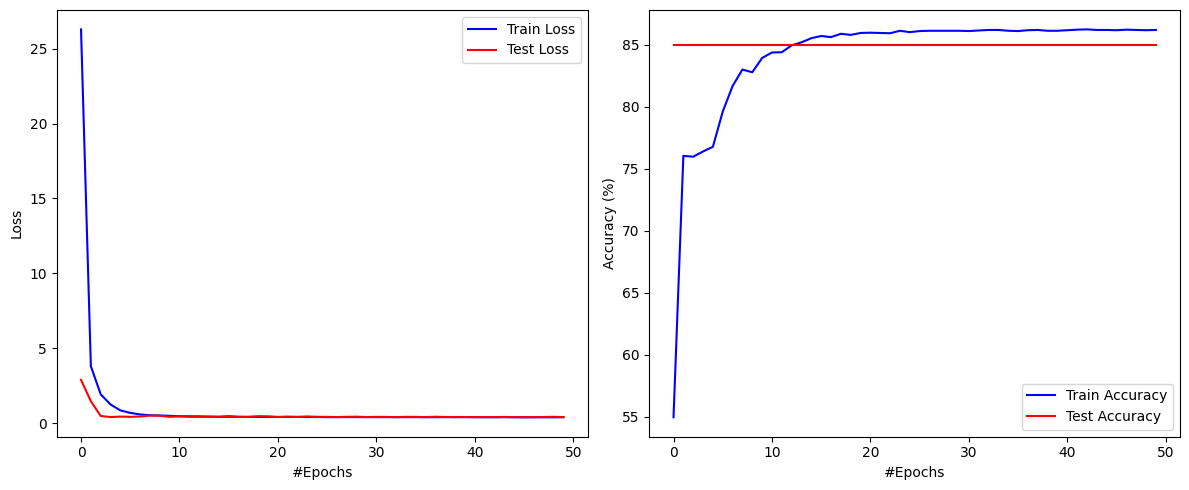

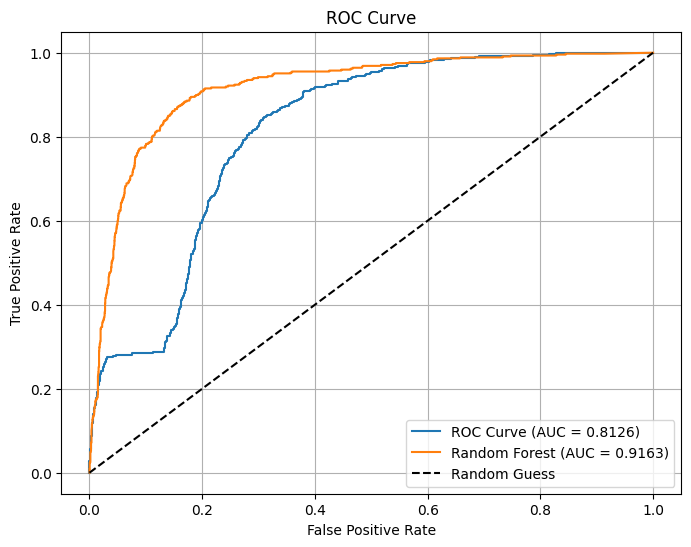

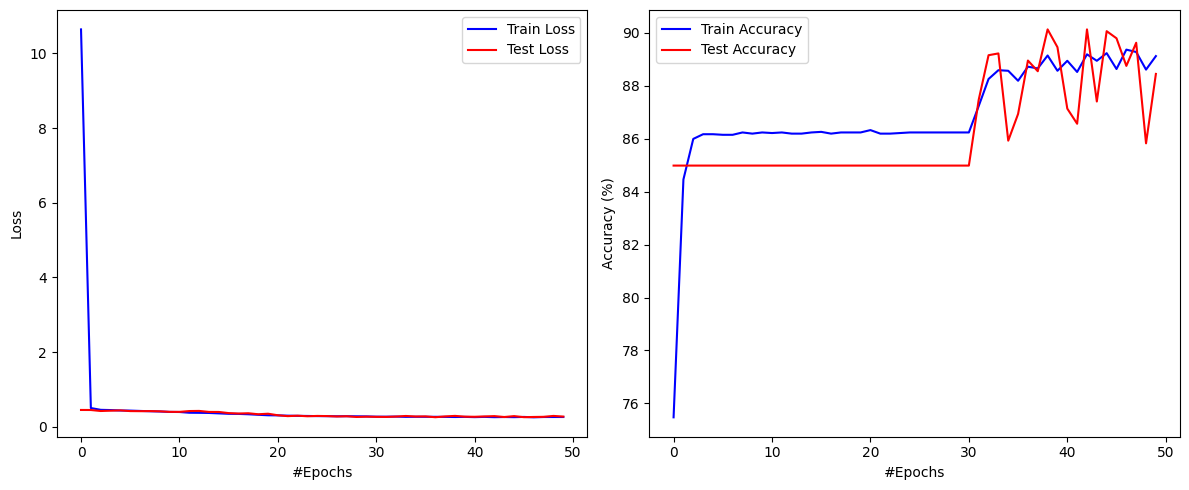

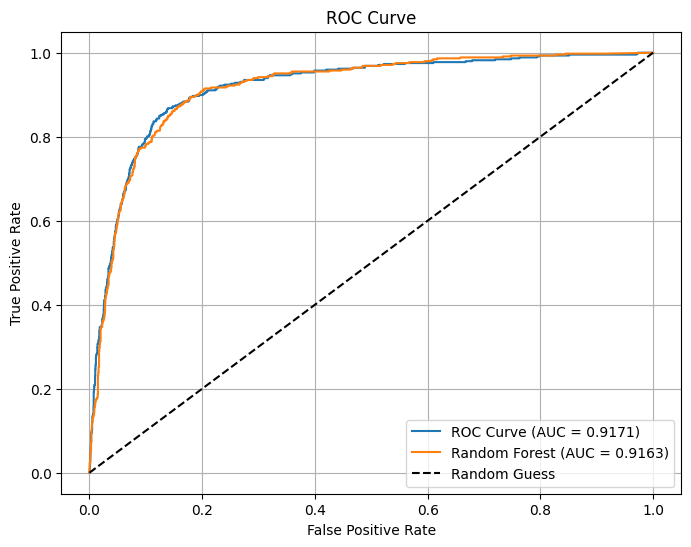

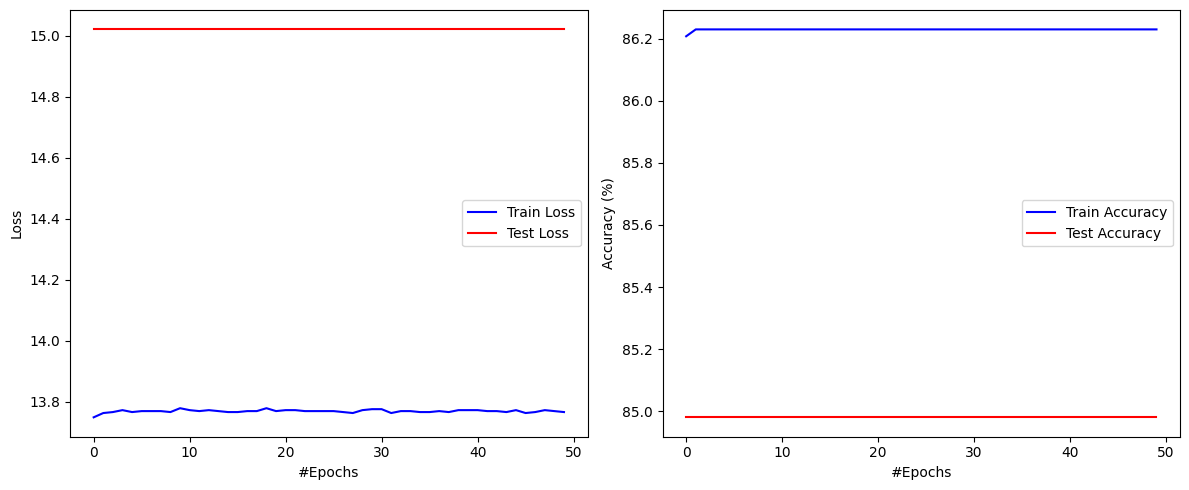

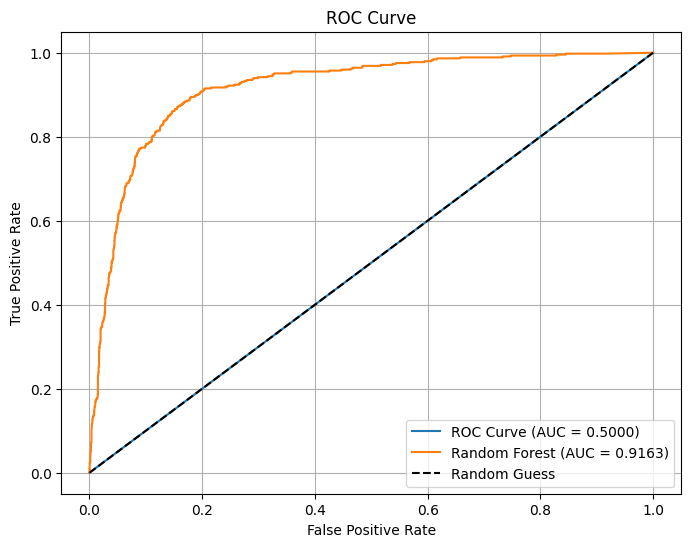

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from itertools import product
from sklearn.metrics import accuracy_score, f1_score

# Define hyperparameter ranges
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [16]
num_epochs_list = [50]
print_interval = 5


# Assume X_train, X_test, y_train, y_test, NumpyDataset, F1PodiumPredictor, trainAndGraph are defined

# Prepare datasets
training_dataset = NumpyDataset(X_train.values, y_train.values)
testing_dataset = NumpyDataset(X_test.values, y_test.values)

# Initialize results storage
results = []

# Perform grid search
for learning_rate, batch_size, num_epochs in product(learning_rates, batch_sizes, num_epochs_list):
    print(f"\nTesting: lr={learning_rate}, batch_size={batch_size}, epochs={num_epochs}")

    # Set up data loaders
    training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

    # Initialize model and optimizer
    input_size = X_train.shape[1]
    model = F1PodiumPredictor(input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.BCELoss()

    # Train model and get predictions
    final_targets, final_preds = trainAndGraph(
        model,
        training_generator,
        testing_generator,
        loss_function,
        optimizer,
        num_epochs,
        learning_rate,
        print_interval
    )

    # Calculate metrics
    final_preds_binary = (np.array(final_preds) > 0.5).astype(int)
    final_targets_np = np.array(final_targets)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(final_targets_np, final_preds_binary)
    f1 = f1_score(final_targets_np, final_preds_binary)

    # Store results with targets and predictions
    results.append({
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'accuracy': accuracy,
        'f1_score': f1,
        'final_targets': final_targets_np.tolist(),
        'final_preds': final_preds_binary.tolist()
    })

    print(f"Results: Accuracy={accuracy:.4f}, F1 Score={f1:.4f}")

# Return results
print("\nHyperparameter tuning completed. Results:")
for result in results:
    print(f"lr={result['learning_rate']}, batch_size={result['batch_size']}, "
          f"epochs={result['num_epochs']}, Accuracy={result['accuracy']:.4f}, "
          f"F1 Score={result['f1_score']:.4f}")
    print(f"Final Targets: {result['final_targets'][:5]}...")
    print(f"Final Predictions: {result['final_preds'][:5]}...")




Loaded Data
Epoch [1/50], Train Loss: 7.4417, Train Acc: 78.82%, Test Loss: 0.4212, Test Acc: 84.98%
Epoch [6/50], Train Loss: 0.4197, Train Acc: 86.01%, Test Loss: 0.4225, Test Acc: 84.98%
Epoch [11/50], Train Loss: 0.4083, Train Acc: 86.14%, Test Loss: 0.4208, Test Acc: 84.98%
Epoch [16/50], Train Loss: 0.3977, Train Acc: 86.23%, Test Loss: 0.4101, Test Acc: 84.98%
Epoch [21/50], Train Loss: 0.3653, Train Acc: 86.23%, Test Loss: 0.3902, Test Acc: 84.98%
Epoch [26/50], Train Loss: 0.3411, Train Acc: 86.21%, Test Loss: 0.4105, Test Acc: 84.98%
Epoch [31/50], Train Loss: 0.3138, Train Acc: 86.21%, Test Loss: 0.3684, Test Acc: 84.98%
Epoch [36/50], Train Loss: 0.2951, Train Acc: 86.27%, Test Loss: 0.3079, Test Acc: 84.98%
Epoch [41/50], Train Loss: 0.2759, Train Acc: 86.98%, Test Loss: 0.2801, Test Acc: 86.56%
Epoch [46/50], Train Loss: 0.2722, Train Acc: 88.36%, Test Loss: 0.2750, Test Acc: 86.26%

Final Test Metrics:
Accuracy: 0.8686
Precision: 0.7222
Recall: 0.2036
F1 Score: 0.3176
AU

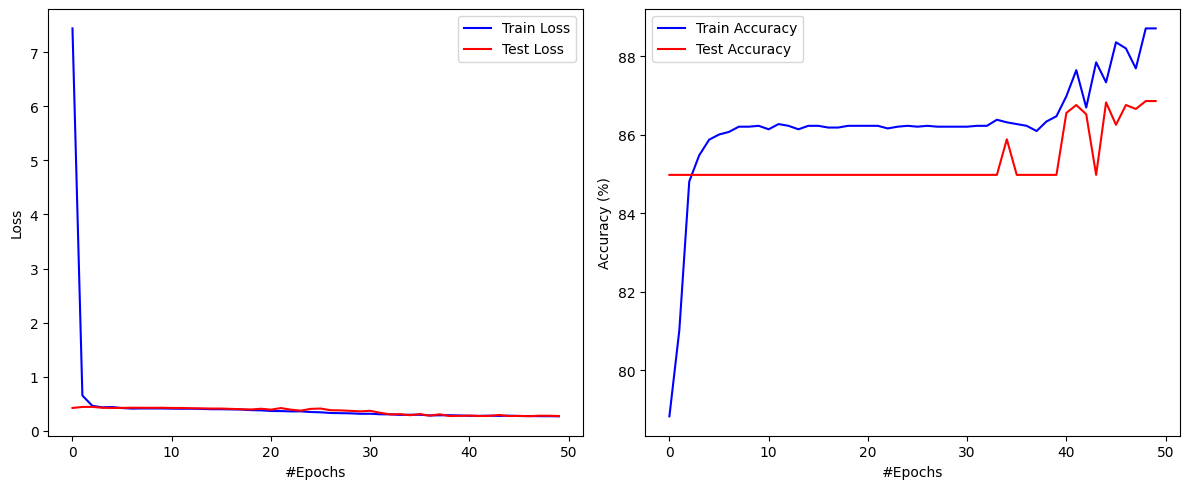

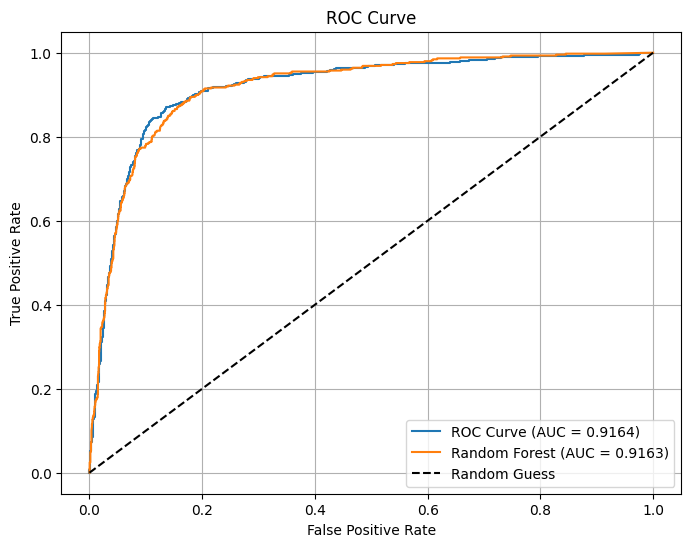

In [ ]:
training_dataset = NumpyDataset(X_train.values, y_train.values)
testing_dataset = NumpyDataset(X_test.values, y_test.values)

num_epochs = 50
print_interval = 5
learning_rate = 0.001
batch_size = 32

input_size = X_train.shape[1]

model = F1PodiumPredictor(input_size)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.BCELoss()

training_generator = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)

print("Loaded Data")
final_targets, final_preds = trainAndGraph(model, training_generator, testing_generator, loss_function, optimizer, num_epochs, learning_rate, print_interval)


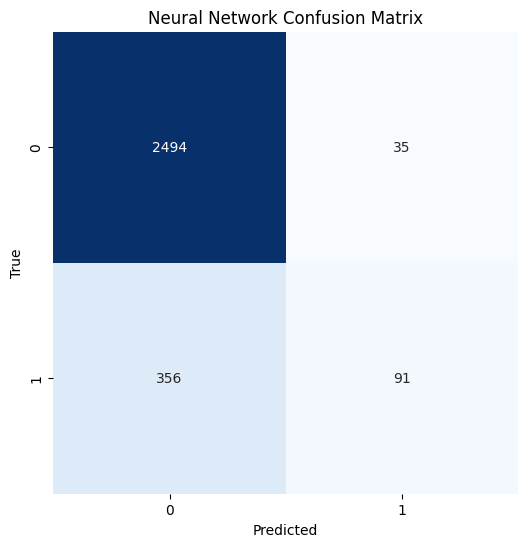

In [ ]:
cm = confusion_matrix(final_targets, final_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Neural Network Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')

In [ ]:
print(X_train.shape[1])

6
